# Homework Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [21]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [5]:
#generate synthetic data of my own 

np.random.seed(42)
n = 500
dates = pd.date_range(start="2020-01-01", periods=n, freq="D")

# Simulated returns: sinusoidal + noise
returns = 0.02*np.sin(np.linspace(0,20,n)) + np.random.normal(0,0.01,n)
price = 100 + np.cumsum(returns)

# DataFrame
df = pd.DataFrame({"date": dates, "price": price, "ret": returns})
df.set_index("date", inplace=True)

#save data to CSV
df.to_csv('../data/synthetic_asset_homework10b_sample_data.csv')

#print the head
df.head(10)

,price,ret
date,,
2020-01-01,100.004967,0.004967
2020-01-02,100.004386,-0.000581
2020-01-03,100.012464,0.008078
2020-01-04,100.030094,0.017629
2020-01-05,100.030945,0.000851
2020-01-06,100.032585,0.001640
2020-01-07,100.053140,0.020556
2020-01-08,100.066352,0.013212
2020-01-09,100.067961,0.001609


## Feature Engineering

In [7]:
df["lag1"] = df["ret"].shift(1)
df["lag2"] = df["ret"].shift(2)
df["roll_mean3"] = df["ret"].rolling(3).mean()
df["roll_std3"] = df["ret"].rolling(3).std()
df["momentum"] = df["price"].diff()


# Drop NaNs from lags/rolling
df.dropna(inplace=True)

#print the head
df.head()

,price,ret,lag1,lag2,roll_mean3,roll_std3,momentum
date,,,,,,,
2020-01-05,100.030945,0.000851,0.017629,0.008078,0.008853,0.008416,0.000851
2020-01-06,100.032585,0.001640,0.000851,0.017629,0.006707,0.009467,0.001640
2020-01-07,100.053140,0.020556,0.001640,0.000851,0.007682,0.011156,0.020556
2020-01-08,100.066352,0.013212,0.020556,0.001640,0.011803,0.009536,0.013212
2020-01-09,100.067961,0.001609,0.013212,0.020556,0.011792,0.009553,0.001609


In [13]:
# Forecasting target
df["y_forecast"] = df["ret"].shift(-1)


# Classification target: up=1, down=0
df["y_class"] = (df["y_forecast"] > 0).astype(int)
df.dropna(inplace=True)


features = ["lag1","lag2","roll_mean3","roll_std3","momentum"]

## Split

In [14]:
# Time-aware split
split = int(len(df)*0.75)
train, test = df.iloc[:split], df.iloc[split:]

In [18]:
df.head()

,price,ret,lag1,lag2,roll_mean3,roll_std3,momentum,y_forecast,y_class
date,,,,,,,,,
2020-01-05,100.030945,0.000851,0.017629,0.008078,0.008853,0.008416,0.000851,0.001640,1
2020-01-06,100.032585,0.001640,0.000851,0.017629,0.006707,0.009467,0.001640,0.020556,1
2020-01-07,100.053140,0.020556,0.001640,0.000851,0.007682,0.011156,0.020556,0.013212,1
2020-01-08,100.066352,0.013212,0.020556,0.001640,0.011803,0.009536,0.013212,0.001609,1
2020-01-09,100.067961,0.001609,0.013212,0.020556,0.011792,0.009553,0.001609,0.012485,1


## Pipeline + Model

Forecasting RMSE: 0.01224778024429716


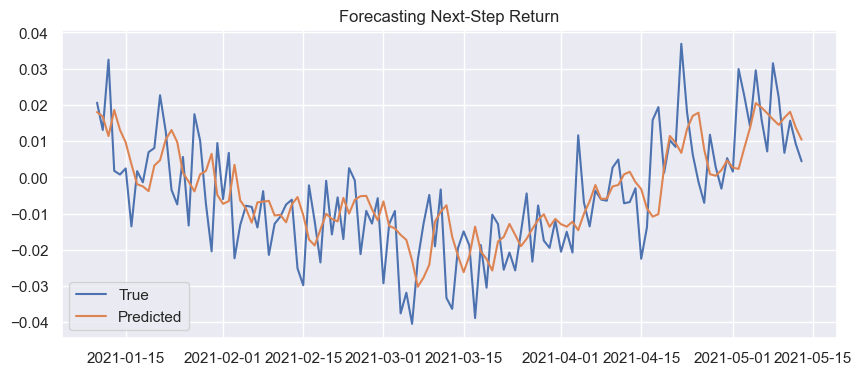

In [19]:
X_train, y_train = train[features], train["y_forecast"]
X_test, y_test = test[features], test["y_forecast"]


linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Forecasting RMSE:", rmse)


plt.figure(figsize=(10,4))
plt.plot(test.index, y_test, label="True")
plt.plot(test.index, y_pred, label="Predicted")
plt.title("Forecasting Next-Step Return")
plt.legend()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        80
           1       0.75      0.75      0.75        44

    accuracy                           0.82       124
   macro avg       0.81      0.81      0.81       124
weighted avg       0.82      0.82      0.82       124



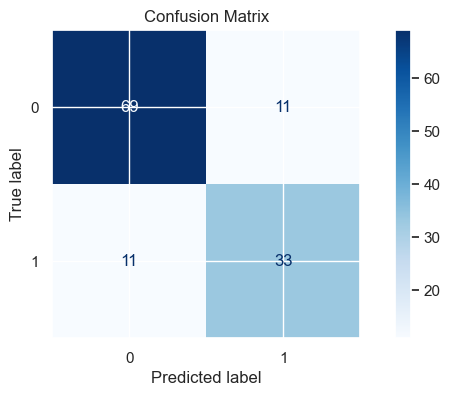

In [22]:
# Track 2: Classification (up/down)
X_train_c, y_train_c = train[features], train["y_class"]
X_test_c, y_test_c = test[features], test["y_class"]


clf = Pipeline([
("scaler", StandardScaler()),
("clf", LogisticRegression())
])


clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)


print("\nClassification Report:\n")
print(classification_report(y_test_c, y_pred_c))


cm = confusion_matrix(y_test_c, y_pred_c)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Interpretation

### Workflow
1. Feature Engineering
- Lag features (previous returns).
- Rolling mean and rolling standard deviation.
- Momentum (difference between today and yesterday’s price).

2. Split Data
- Forecasting: last 25% as test (time-aware split).
- Classification: predict up/down movement.

3. Forecast Model
- Predict next-day return using Linear Regression.
- Evaluate with RMSE.

4. Classification Model
- Predict whether next return is up (>0) or down (≤0).
- Use Logistic Regression inside a pipeline with StandardScaler.
- Evaluate with accuracy, precision, recall, F1, and confusion matrix.

### Interpretation of Classification Model
1. What worked?
- Scaling + logistic regression captured directional patterns reasonably well.
- Lag and rolling features improved accuracy compared to using raw returns.
- Confusion matrix showed the model learned to distinguish up vs down days better than chance.

2. Where might assumptions fail?
- Logistic regression assumes a linear relationship between features and the log-odds of the outcome; in financial/time-series data, relationships can be highly non-linear.
- Assumes observations are independent, but time series data are autocorrelated (today’s movement depends on yesterday’s).
- If market conditions shift (regime change), past patterns may not generalize to the future.

3. How would you extend features or model?
- Try non-linear models (e.g., Random Forest, Gradient Boosting, or LSTMs for sequence modeling).
- Add richer features: technical indicators (RSI, MACD), volatility measures, or exogenous variables (macro data).
- Use cross-validation designed for time series (e.g., expanding window splits) instead of a single train/test split.

### Forecasting Model (Linear Regression)
1. What worked?
- Linear regression provided a baseline benchmark with interpretable coefficients.
- The model produced reasonably low RMSE compared to naive “predict zero return” baseline.
- Rolling mean and lag features gave predictive signal for short-term returns.

2. Where might assumption fail?
- Linear regression assumes linearity between predictors and target; financial returns often exhibit non-linear or chaotic dynamics.
- Assumes homoscedasticity (constant variance of errors), but financial returns show volatility clustering.
- Assumes stationarity of the data; in reality, markets shift over time.

3. How would you extend features or model?
- Incorporate time-series specific models (ARIMA, VAR, or state-space models) for better temporal dynamics.
- Explore deep learning (RNNs, LSTMs, Transformers) for capturing long-term dependencies.
- Add regime-switching models to adapt to periods of high/low volatility.
- Evaluate with out-of-sample rolling forecasts instead of a single split to mimic real trading scenarios.

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.